# IMPORTS

In [1]:
import transformed_data as data
import dataframeinfo as info
import pandas as pd
import numpy as np
import missingno as msno

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

# LOAD DATA

In [3]:
# Assign data from transformed_data to variable "loans". 
loans = data.loans
loans.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.0,0.0,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,150 days 00:00:00,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.0,0.0,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaT,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.0,0.0,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaT,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.0,0.0,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaT,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.0,0.0,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaT,1,INDIVIDUAL


# SUMMARY OUTCOMES

## Decision on missing data
- **funded_amount**: impute from loan_amount - highly correlated (0.99). Done.
- **term_months**: fill based on total_int_rec values - if > 13619.26 fill to 60, else 36.
- **int_rate**: fill with median. Mid range of distribution is fairly normal. Some positive skew. 
- **employment_years**: fill with mode. Mode strongly outweighs other values. Also, data was converted to numeric for initial analysis but is ordinal. 
- **mths_since_last_delinq**: possibly drop column, high rate of nulls (57%). --> Data very skewed - drop column. 
- **mths_since_last_record**: drop column, >80% missing.
- **last_payment_date**: replace missing values with mode - far outweighs all other values. Heavy skew to most recent date (also mode).
- **next_payment_date**: replace missing values with mode - far outweighs all other values. Heavy skew to most recent date (also mode).
- **last_credit_pull_date**: drop missing rows (< 0.01 %)
- **collections_12_mths_ex_med**: drop missing rows (< 0.09 %)
- **mths_since_last_major_derog**: drop column, >80% missing.

# DATA ANALYSIS

In [4]:
# Create instance of the DataFrameInfo class.
loans_info = info.DataFrameInfo(loans)

In [5]:
loans_info.percent_na()

Column               Missing values (%) 
 funded_amount                   5.54
term_months                     8.80
int_rate                        9.53
employment_min_years            3.91
mths_since_last_delinq         57.17
mths_since_last_record         88.60
last_payment_date               0.13
next_payment_date              60.13
last_credit_pull_date           0.01
collections_12_mths_ex_med      0.09
mths_since_last_major_derog    86.17
dtype: float64


In [6]:
loans_info.count_na()

Column                Missing values 
 funded_amount                   3007
term_months                     4772
int_rate                        5169
employment_min_years            2118
mths_since_last_delinq         31002
mths_since_last_record         48050
last_payment_date                 73
next_payment_date              32608
last_credit_pull_date              7
collections_12_mths_ex_med        51
mths_since_last_major_derog    46732
dtype: int64


In [7]:
class Plotter:
    def __init__ (self, data):
        self.data = data
        self.ax = None

    def msno_plot(self):
        msno.matrix(self.data)

    def correlation(self, w, h):
        numeric_cols = self.data.select_dtypes(include=["int64", "float64"])
        correlation_matrix = numeric_cols.corr()
        plt.figure(figsize=(w, h))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

    def scatter(self, x, y):
        sns.scatterplot(data=self.data, x=x, y=y)

    def scatter_reg(self, x, y):
        sns.regplot(data=self.data, x=x, y=y, scatter_kws={'s': 10}, line_kws={'color': 'red'})
        plt.gca().set_zorder(1) 
        #model = sm.OLS(self.data[y], sm.add_constant(self.data[x])).fit()
        #plt.text(1.5, 5, f"Y = {model.params[0]:.2f} + {model.params[1]:.2f}X\nR-squared = {model.rsquared:.2f}", fontsize=10)

    def histogram(self, column, bins):
        self.ax = sns.histplot(self.data[column], bins=bins, kde=True)
        return self
        
    def format_hist(self, x_rot, num_labels):
        self.ax.tick_params(axis='x', rotation=x_rot)
        self.ax.xaxis.set_major_locator(plt.MaxNLocator(num_labels))
        #return self
    
    def qq_plot(self, column):
        qqplot(self.data[column], scale=1, line='q')

    def k2_test(self, column):
        data = self.data[column]
        # D’Agostino’s K^2 Test
        stat, p = normaltest(data, nan_policy='omit')
        print('K^2 test statistic = %.3f, p = %.3f' % (stat, p))

    def dpd_plot(self, column, x_rot):
        probabilities = self.data[column].value_counts(normalize=True)
        dpd = sns.barplot(y=probabilities.values, x=probabilities.index)
        plt.ylabel("Probability")
        plt.xticks(rotation=x_rot)
        


In [8]:
# Create instance of the Plotter class. 
loans_plots = Plotter(loans)

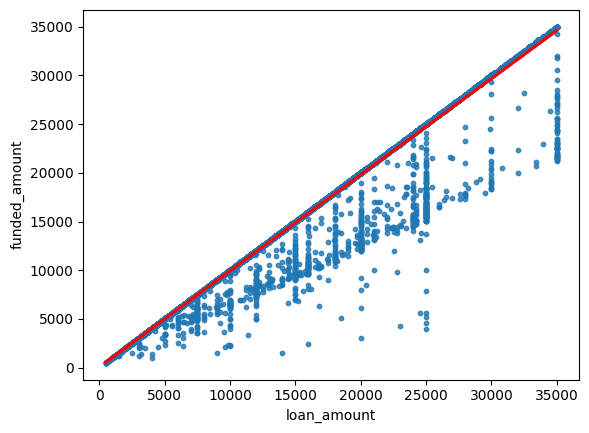

In [9]:
loans_plots.scatter_reg("loan_amount", "funded_amount")

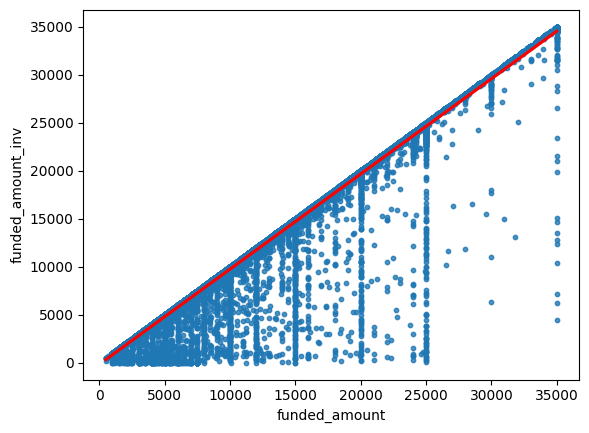

In [10]:
loans_plots.scatter_reg("funded_amount", "funded_amount_inv")

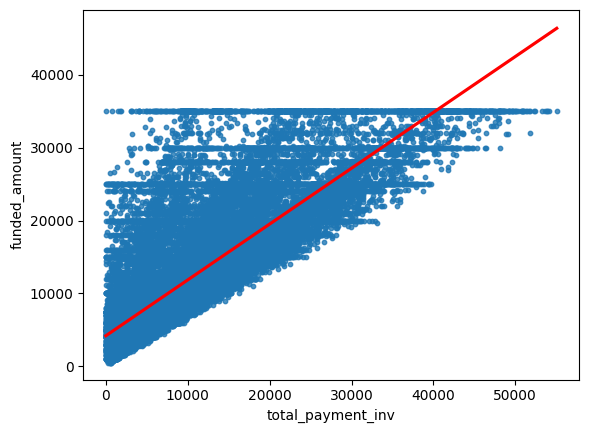

In [11]:
loans_plots.scatter_reg("total_payment_inv", "funded_amount")

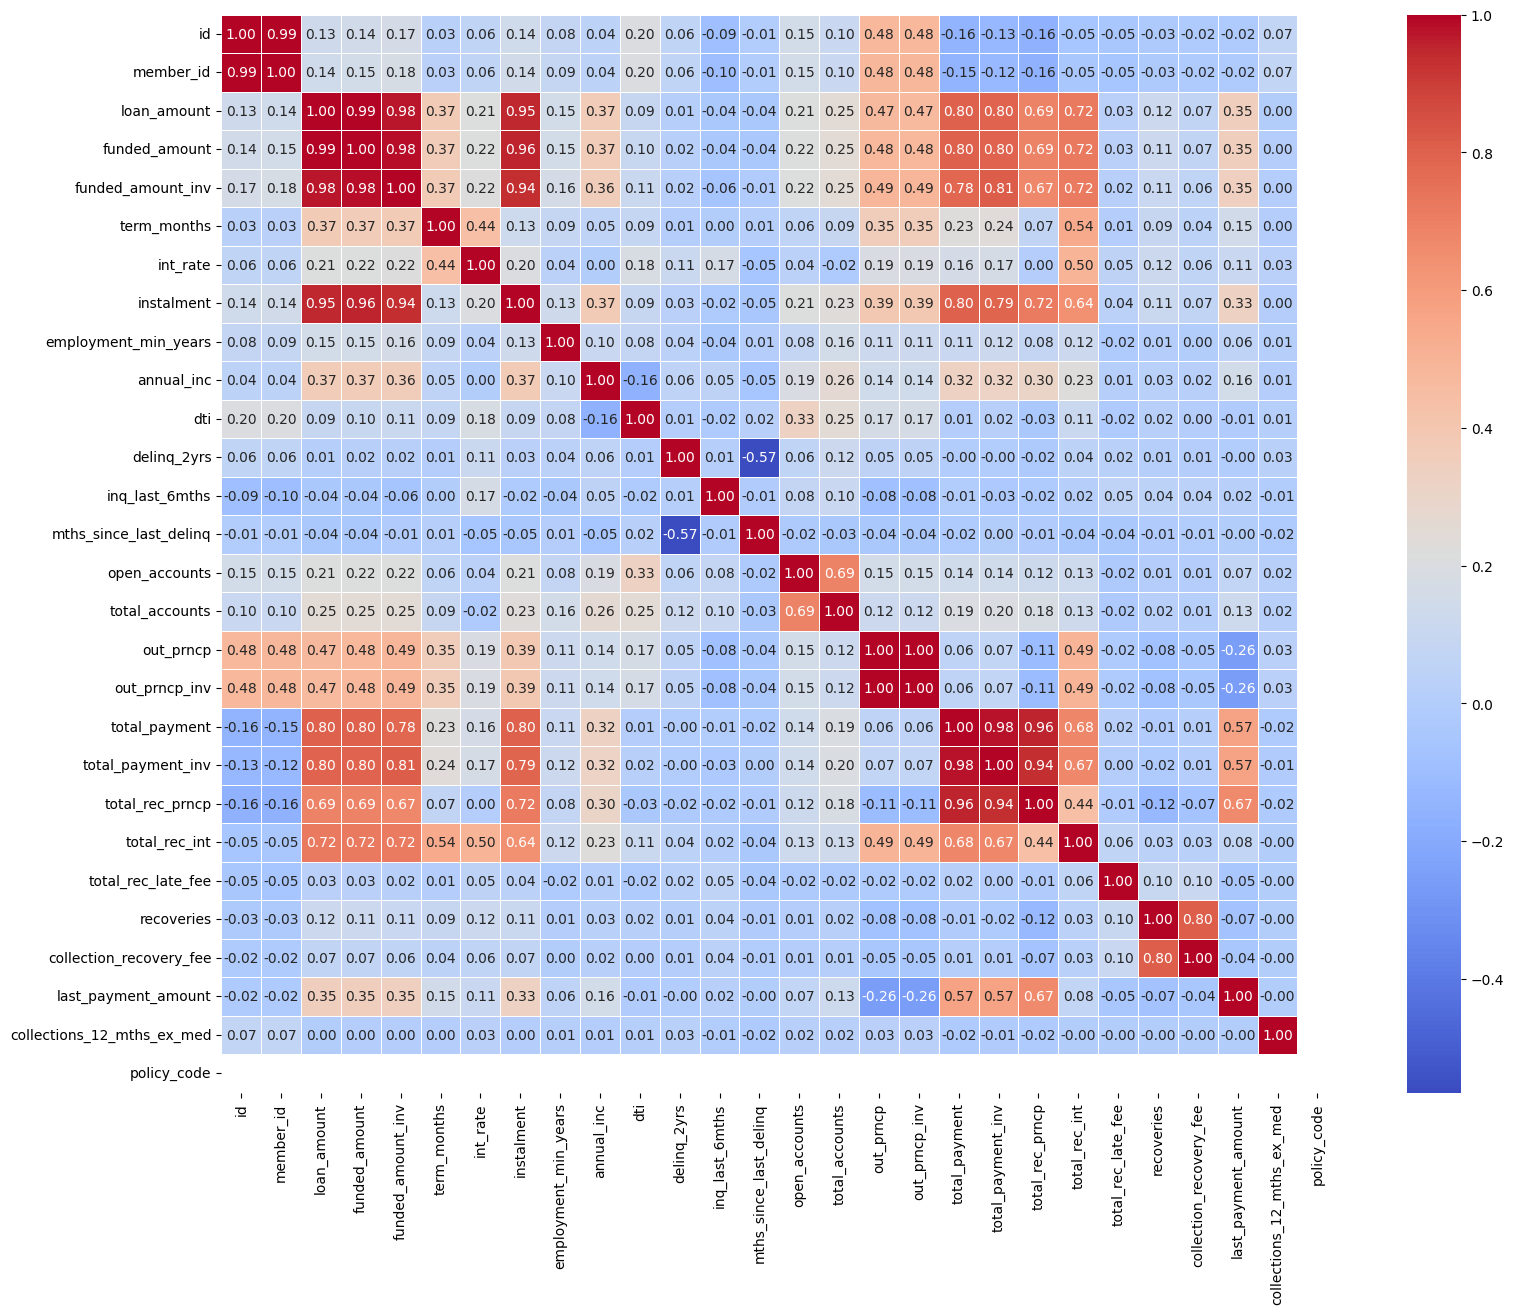

In [12]:
loans_plots.correlation(18, 14)

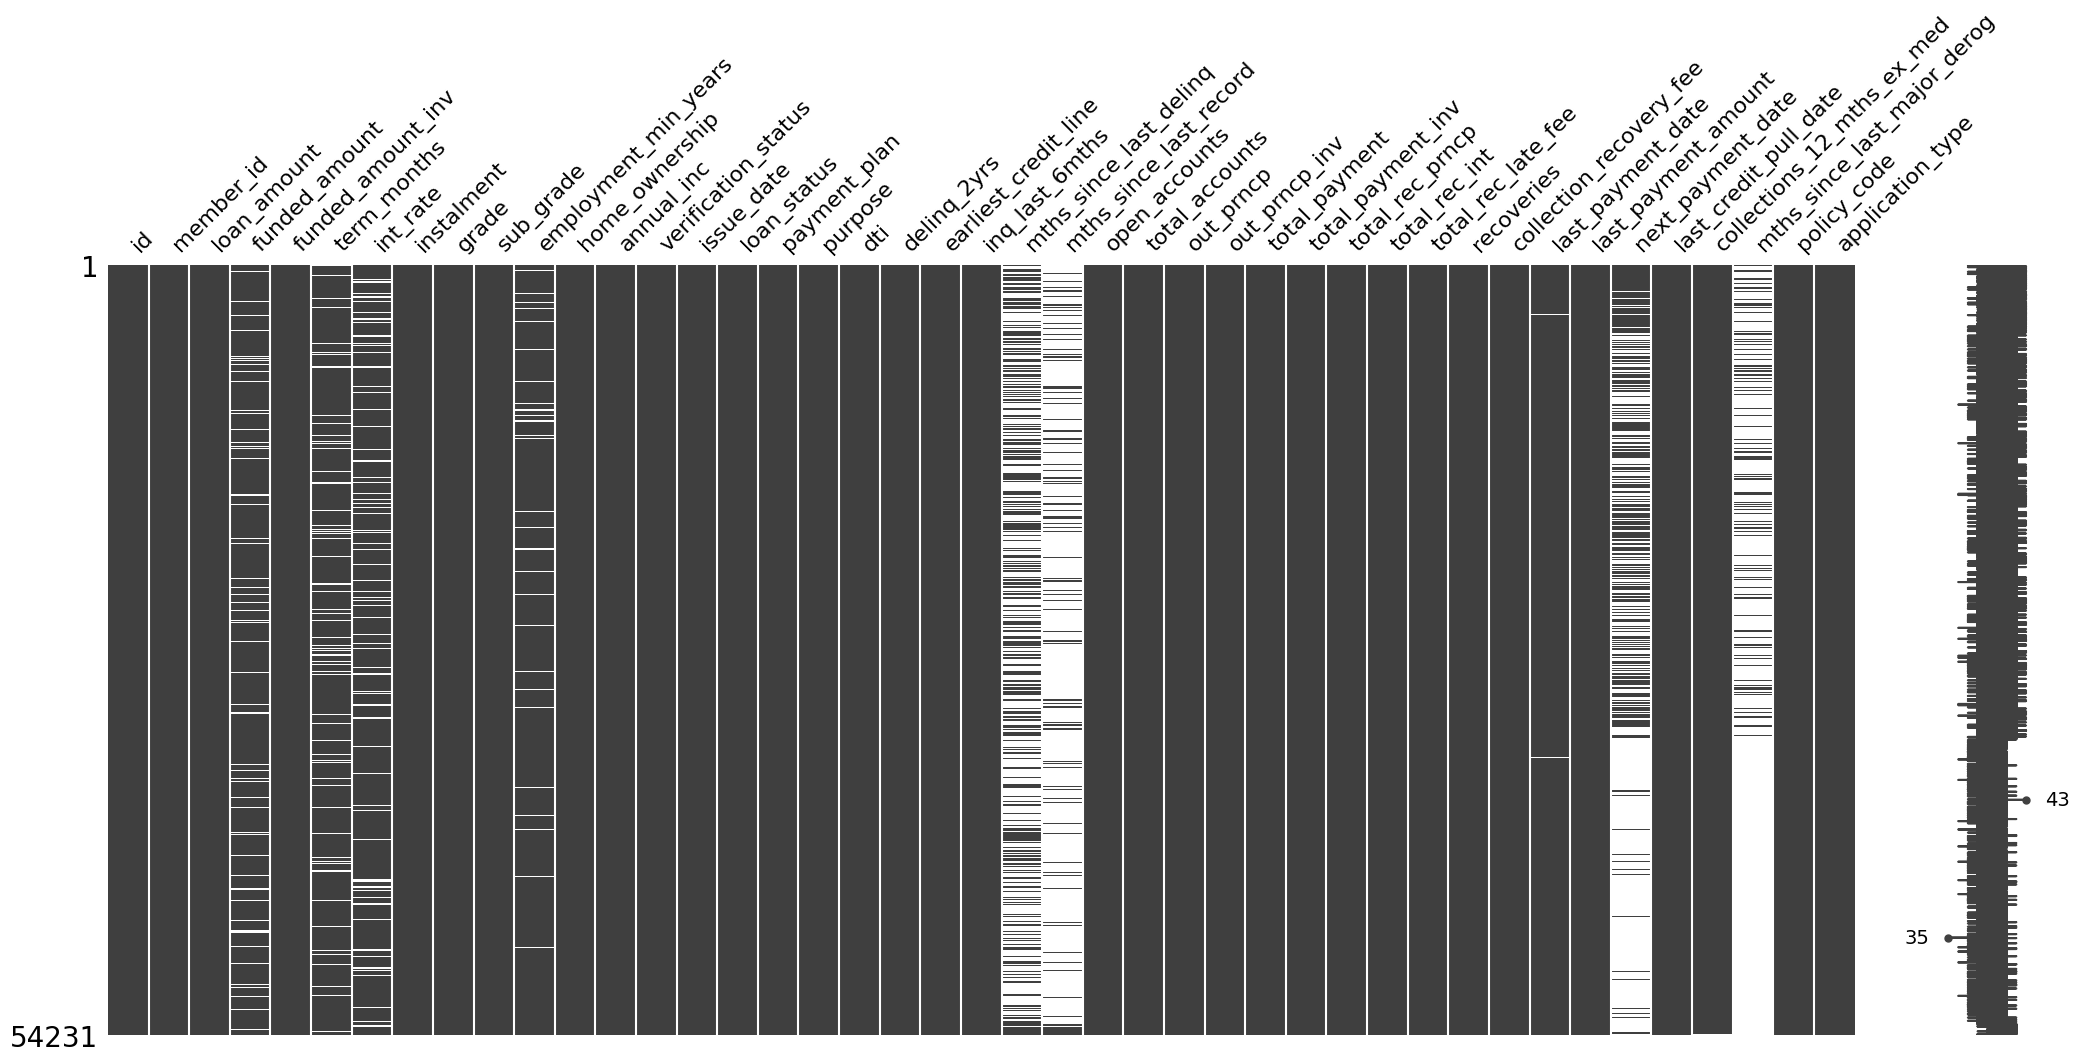

In [13]:
loans_plots.msno_plot()

In [14]:
loans_info.dtypes()

Column                        Data type 
 id                                      int64
member_id                               int64
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term_months                           float64
int_rate                              float64
instalment                            float64
grade                                category
sub_grade                            category
employment_min_years                  float64
home_ownership                       category
annual_inc                            float64
verification_status                    object
issue_date                      datetime64[s]
loan_status                            object
payment_plan                         category
purpose                                object
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line            dateti

funded_amount: 
 mean: 13229.509 
 median: 12000.0 
 mode: 10000.0 
 standard deviation: 8019.018


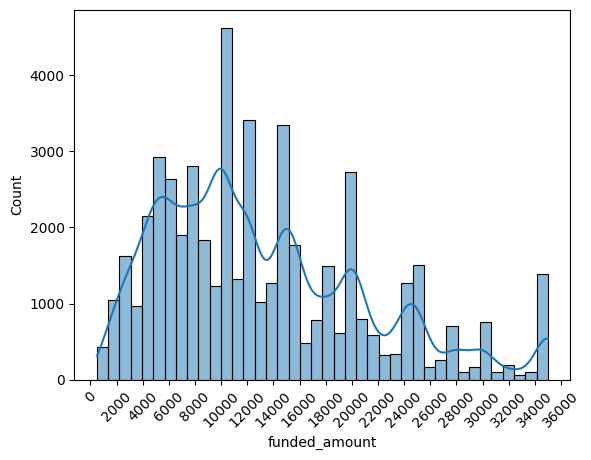

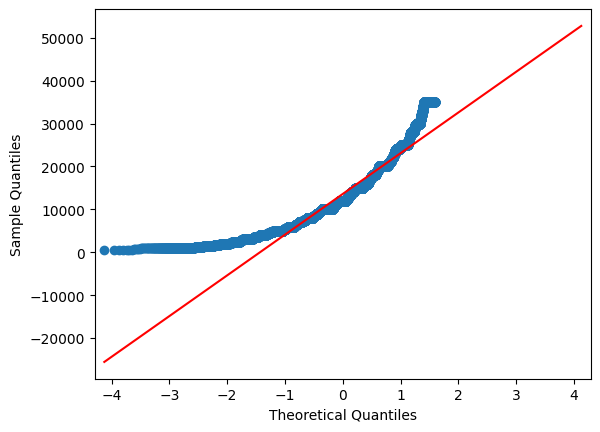

In [15]:
loans_plots.histogram("funded_amount", 40).format_hist(45, 20)
loans_plots.qq_plot("funded_amount")
loans_info.column_stats("funded_amount")

loan_amount: 
 mean: 13333.076 
 median: 12000.0 
 mode: 10000 
 standard deviation: 8082.197


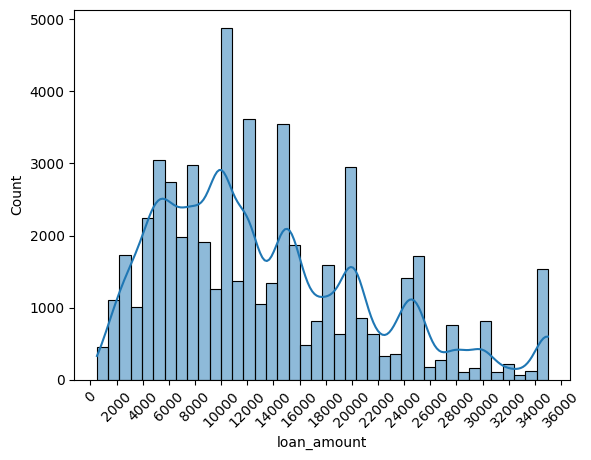

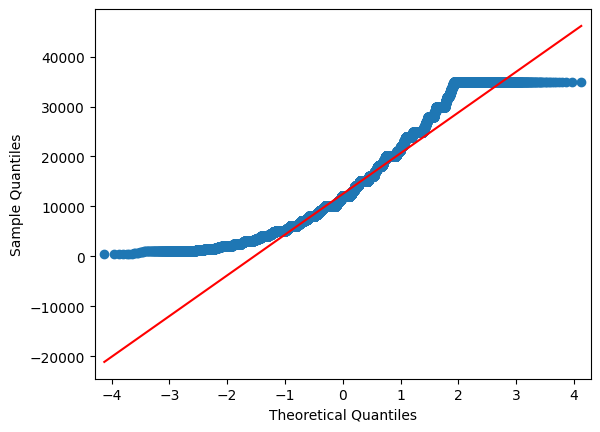

In [16]:
loans_plots.histogram("loan_amount", 40).format_hist(45, 20)
loans_plots.qq_plot("loan_amount")
loans_info.column_stats("loan_amount")

term_months: 
 mean: 42.606 
 median: 36.0 
 mode: 36.0 
 standard deviation: 10.72


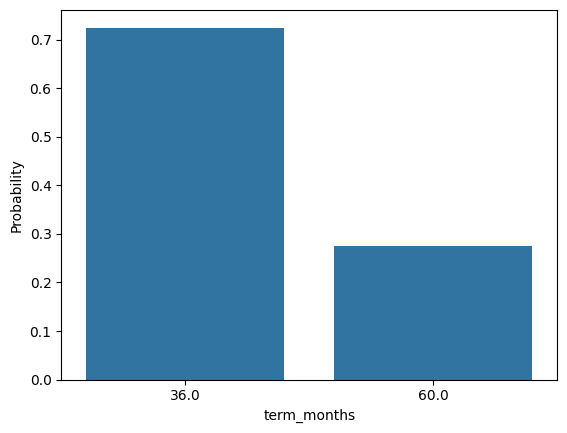

In [17]:
loans_plots.dpd_plot("term_months", 0)
loans_info.column_stats("term_months")

13619.26


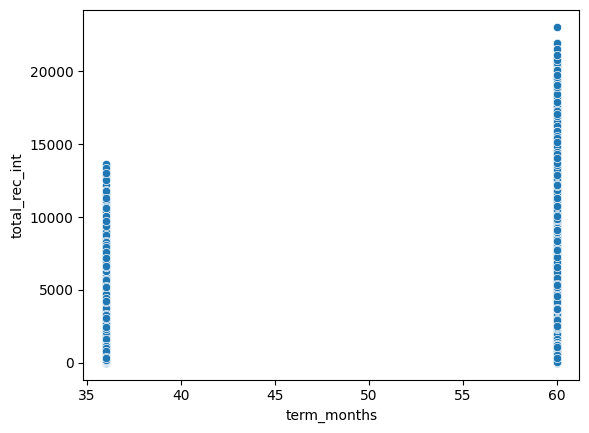

In [18]:
# term_months has some correlation (0.54) with total_rec_int. Create scatter.
loans_plots.scatter("term_months", "total_rec_int")
lower_term_data = loans[loans["term_months"] < 60.0]
print(max(lower_term_data["total_rec_int"]))
# If total_rec_int > 13619.26 fill term_months nulls to 60.0, else fill to 36.0.

int_rate: 
 mean: 13.507 
 median: 13.16 
 mode: 11.99 
 standard deviation: 4.393
K^2 test statistic = 1421.934, p = 0.000


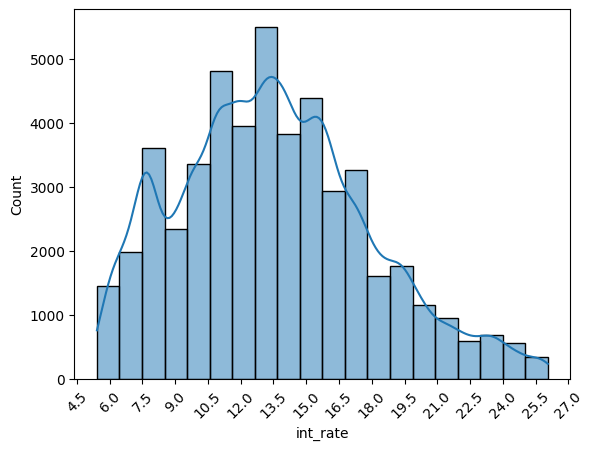

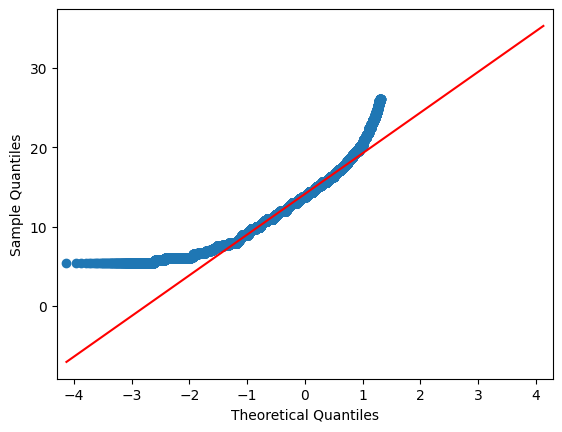

In [19]:
# Histogram and stats on int_rate (9.53% missing).
loans_plots.histogram("int_rate", 20).format_hist(45, 20)
loans_plots.qq_plot("int_rate")
loans_info.column_stats("int_rate")
loans_plots.k2_test("int_rate")
# Normality test indicates non-normal distribution. 
# Visualisation and column stats show slight positive skew. Likely best to fill nulls with median. 

employment_min_years: 
 mean: 5.691 
 median: 6.0 
 mode: 10.0 
 standard deviation: 3.649


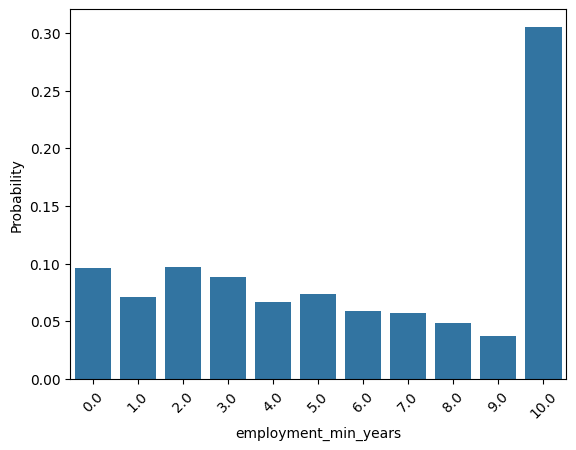

In [20]:
loans_info.column_stats("employment_min_years")
loans_plots.dpd_plot("employment_min_years", 45)
# High probability that employment length is greater than 10 years. Change data type and check correlations. Done. No correlations. Take mode. 

mths_since_last_delinq: 
 mean: 34.019 
 median: 31.0 
 mode: 9.0 
 standard deviation: 21.923


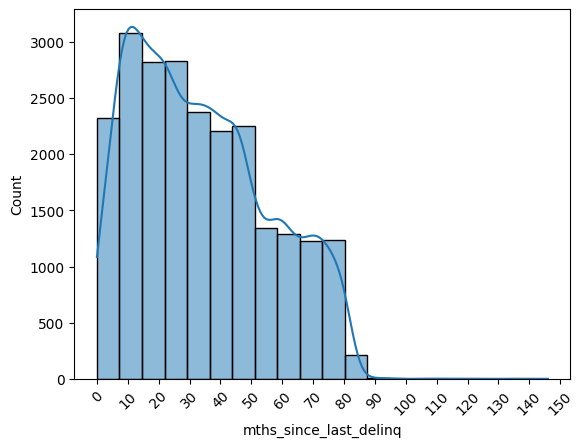

In [34]:
loans_info.column_stats("mths_since_last_delinq")
loans_plots.histogram("mths_since_last_delinq", 20).format_hist(45, 20)

last_credit_pull_date: 
 mean: 2021-04-15 16:16:28 
 median: 2022-01-01 00:00:00 
 mode: 2022-01-01 00:00:00 
 standard deviation: 473 days 08:18:38


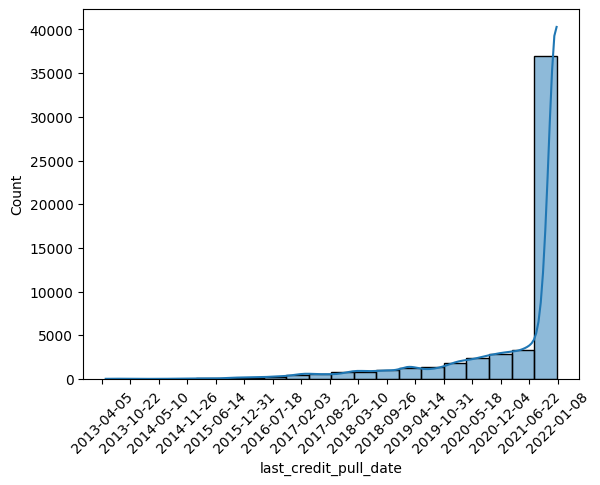

In [22]:
loans_plots.histogram("last_credit_pull_date", 20).format_hist(45, 20)
loans_info.column_stats("last_credit_pull_date")

next_payment_date: 
 mean: 2021-10-18 16:47:47 
 median: 2022-02-01 00:00:00 
 mode: 2022-02-01 00:00:00 
 standard deviation: 418 days 12:25:32


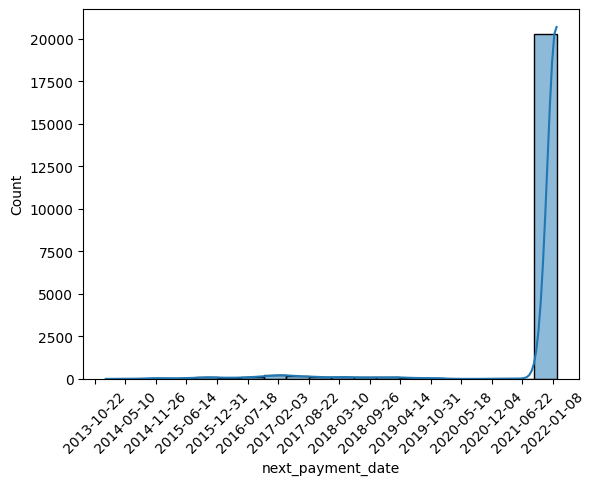

In [23]:
loans_plots.histogram("next_payment_date", 20).format_hist(45, 20)
loans_info.column_stats("next_payment_date")

collections_12_mths_ex_med: 
 mean: 0.004 
 median: 0.0 
 mode: 0.0 
 standard deviation: 0.071


collections_12_mths_ex_med
0.0    99.6142
1.0     0.3562
2.0     0.0258
3.0     0.0018
4.0     0.0018
Name: count, dtype: float64

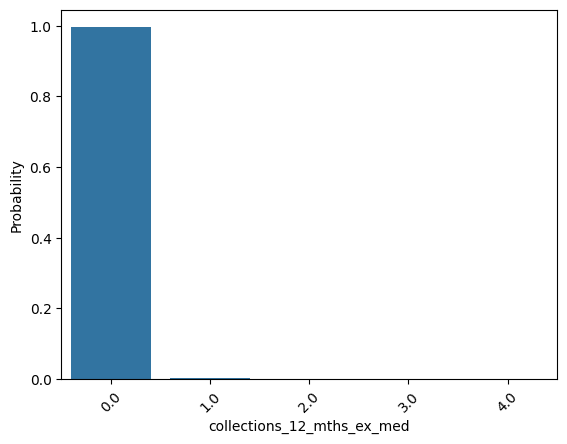

In [24]:
loans_plots.dpd_plot("collections_12_mths_ex_med", 45)
loans_info.column_stats("collections_12_mths_ex_med")
loans["collections_12_mths_ex_med"].value_counts()/len(loans["collections_12_mths_ex_med"].dropna()) * 100

# DATA CLEANING

In [25]:
class DataFrameTransform:
    def __init__ (self, data):
        self.data = data

    def calc_corr(self, col_y, col_x):
        correlation = self.data[col_y].corr(self.data[col_x])
        return correlation

    def corr_impute(self, col_y, col_x):
        corr = self.calc_corr(col_y, col_x)
        
        def impute(row):
            if pd.isnull(row[col_y]):
                return row[col_x] * corr
            else:
                return row[col_y]

        self.data[col_y] = self.data.apply(impute, axis=1)

In [26]:
# Create instance of the DataFrameTransform class. 
loans_cleaning = DataFrameTransform(loans)

In [27]:
# Impute missing values in funded_amount, based on correlation with loan_amount. 
loans_cleaning.corr_impute("funded_amount", "loan_amount")

In [28]:
loans_cleaned = info.DataFrameInfo(loans)

In [29]:
loans_cleaned.percent_na()

Column               Missing values (%) 
 term_months                     8.80
int_rate                        9.53
employment_min_years            3.91
mths_since_last_delinq         57.17
mths_since_last_record         88.60
last_payment_date               0.13
next_payment_date              60.13
last_credit_pull_date           0.01
collections_12_mths_ex_med      0.09
mths_since_last_major_derog    86.17
dtype: float64


funded_amount: 
 mean: 13230.079 
 median: 11927.355 
 mode: 10000.0 
 standard deviation: 8023.842


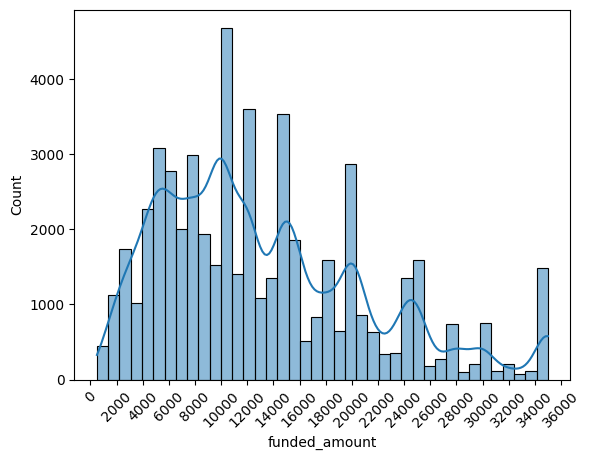

In [30]:
# Check data after imputing funded_amount.
loans_plots.histogram("funded_amount", 40).format_hist(45, 20)
loans_info.column_stats("funded_amount")